In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Part A: Data preprocessing and feature engineering

In [2]:
df_Trans=pd.read_csv(r"./Data/HI-Small_Trans.csv")
df_Banks=pd.read_csv(r"./Data/HI-Small_accounts.csv")

In [3]:
data=df_Trans.copy()
details=df_Banks.copy()
del df_Trans,df_Banks

# Part B: Data Exploration

In [4]:
data.shape

(5078345, 11)

In [5]:
data.head(2)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0


In [6]:
details.head(2)

,Bank Name,Bank ID,Account Number,Entity ID,Entity Name
0,Portugal Bank #4507,331579,80B779D80,80062E240,Sole Proprietorship #50438
1,Canada Bank #27,210,809D86900,800C998A0,Corporation #33520


In [7]:
data['Timestamp']= pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')

In [8]:
data.head(2)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0


### show imbalanced

In [9]:
data["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.898057
1     0.101943
Name: proportion, dtype: float64

### clean

In [10]:
# Check for null values in each column
null_values = data.isnull().sum()

# Check for number of duplicate rows
num_duplicates = data.duplicated().sum()

# Print results
print("Null Values in Each Column:\n", null_values)
print("\nNumber of Duplicate Rows:", num_duplicates)

Null Values in Each Column:
 Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

Number of Duplicate Rows: 9


In [11]:
# 'keep=False' marks all duplicates as True, showing all copies
duplicate_rows = data[data.duplicated(keep=False)]

# Sort them to group the identical rows together
print(duplicate_rows.sort_values(by=list(duplicate_rows.columns)))

                  Timestamp  From Bank    Account  To Bank  Account.1  \
863294  2022-09-01 16:20:00      12004  800C927C1      220  813D8C1E1   
863296  2022-09-01 16:20:00      12004  800C927C1      220  813D8C1E1   
863293  2022-09-01 16:20:00      12004  800C927C1    12004  800C927C0   
863295  2022-09-01 16:20:00      12004  800C927C1    12004  800C927C0   
3684003 2022-09-07 21:25:00      29992  8099A29B1      220  813725AE1   
3684005 2022-09-07 21:25:00      29992  8099A29B1      220  813725AE1   
4166785 2022-09-08 21:05:00     113779  811144AB1    53744  813C777F1   
4166787 2022-09-08 21:05:00     113779  811144AB1    53744  813C777F1   
4166784 2022-09-08 21:05:00     113779  811144AB1   113779  811144AB0   
4166786 2022-09-08 21:05:00     113779  811144AB1   113779  811144AB0   
4510478 2022-09-09 10:03:00       6075  80C702911     6075  80C702910   
4510480 2022-09-09 10:03:00       6075  80C702911     6075  80C702910   
4510479 2022-09-09 10:03:00       6075  80C702911  

In [12]:
# found 8 exact duplicate  rows
data.drop_duplicates(inplace=True)

In [13]:
data.shape

(5078336, 11)

In [14]:
# Removing those banks where no Laundering occured
counts =data.groupby(['From Bank', 'Is Laundering']).size().unstack(fill_value=0)
banks_no_laundering = counts.loc[counts.get(1, 0) == 0].index.tolist()
print(f"(Removed)Banks with no laundering cases: {len(banks_no_laundering)}")
data = data[~data['From Bank'].isin(banks_no_laundering)]

(Removed)Banks with no laundering cases: 29449


In [15]:
data.shape

(4538194, 11)

In [16]:
data["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.885924
1     0.114076
Name: proportion, dtype: float64

### feature engineering

### deal with time

In [17]:
data['weekday'] = data['Timestamp'].dt.weekday
data['hour'] = data['Timestamp'].dt.hour

In [18]:
# If sender is same as reciever then self else out 
data['Type'] = np.where(data['Account'] == data['Account.1'],'self', 'out')

In [19]:
# keeping a count of transactions done over the period by each account
data = data.sort_values('Timestamp')
data['sender_txn_overall_count'] = data.groupby('Account').cumcount() + 1
data['reciever_txn_overall_count'] = data.groupby('Account.1').cumcount() + 1

# keeping a count of transactions done daily by each account
data['sender_txn_daily_count'] = data.groupby(['Account','weekday']).cumcount() + 1
data['reciever_txn_daily_count'] = data.groupby(['Account.1','weekday']).cumcount() + 1

In [20]:
# cleaning the bank details
details['Entity Name']=details['Entity Name'].str.split(' #').str[0]
details['Bank Name']=details['Bank Name'].str.split(' #').str[0]

In [21]:
# Merging data and details
newdf=pd.merge(data,details,left_on='Account',right_on='Account Number')
newdf.drop(columns=['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1','Bank ID','Account Number','Entity ID'],inplace=True)


In [22]:
data.tail(5)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,weekday,hour,Type,sender_txn_overall_count,reciever_txn_overall_count,sender_txn_daily_count,reciever_txn_daily_count
4962230,2022-09-18 10:02:00,9371,8043A0FB0,16163,802F78670,3749.14,US Dollar,3749.14,US Dollar,ACH,1,6,10,out,43,42,2,1
4962231,2022-09-18 11:18:00,9371,8043A0FB0,9371,8043A0FB0,1785.27,Euro,2091.95,US Dollar,ACH,0,6,11,self,44,40,3,4
4962232,2022-09-18 11:18:00,9371,8043A0FB0,13858,8095526B0,1785.27,Euro,1785.27,Euro,ACH,1,6,11,out,45,2,4,1
4962233,2022-09-18 12:58:00,9371,8043A0FB0,1124,8026687E0,2154.54,US Dollar,2154.54,US Dollar,ACH,1,6,12,out,46,4,5,1
4962234,2022-09-18 16:18:00,9371,8043A0FB0,4503,809320130,5448.55,US Dollar,5448.55,US Dollar,ACH,1,6,16,out,47,45,6,3


# Part C: Pipeline for transformations

In [23]:
# numerical
numerical_cols = newdf.select_dtypes(include=np.number).drop(['Is Laundering','weekday','hour'], axis=1).columns.tolist()
# one hot encoding columns 
OHE_cols =['Receiving Currency','Payment Currency','Payment Format','Type','Entity Name','weekday','hour']
# binned columns (binary encoding will be used due to high cardinality)
Bin_cols=['Bank Name']

In [24]:
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce

def create_preprocessor(numerical_cols,OHE_cols,Bin_cols):
    numeric_transformer = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),                                    # impute missing values with mean
        ('scaler', StandardScaler())                                                    # standardize numerical features
    ])
    categorical_transformer1 = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),                           # impute missing values with mode
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))         # one-hot encode categorical if features sees a new category during prediction
        #('Label', OrdinalEncoder())
    ])
    categorical_transformer2 = SklearnPipeline(steps=[                                  # Bin_cols
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary_enc', ce.BinaryEncoder(drop_invariant=True   ))])                      # binary encoding for high cardinality categorical features
        
    preprocessor = ColumnTransformer(                                                   # combine all transformers            
        transformers=[                              
            ('num', numeric_transformer, numerical_cols),                                   
            ('cat1', categorical_transformer1, OHE_cols),                 
            ('cat2', categorical_transformer2, Bin_cols)
        ], remainder='drop'                                                             # keep other columns droppped
    )
    return preprocessor

In [25]:
preproc=create_preprocessor(numerical_cols, OHE_cols, Bin_cols)

In [26]:
X_transformed = preproc.fit_transform(newdf.drop('Is Laundering', axis=1))

In [27]:
X_transformed.shape

(4538231, 91)

# Part D: Oversampling(SMOTE)

split data and fix imbalanced dataset by creating new, synthetic data points for the minority class.

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_transformed, newdf['Is Laundering'],train_size=0.7)

In [39]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(k_neighbors=5)                     

X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

Original class distribution:
Is Laundering
0    3173191
1       3570
Name: count, dtype: int64

Resampled class distribution:
Is Laundering
0    3173191
1    3173191
Name: count, dtype: int64


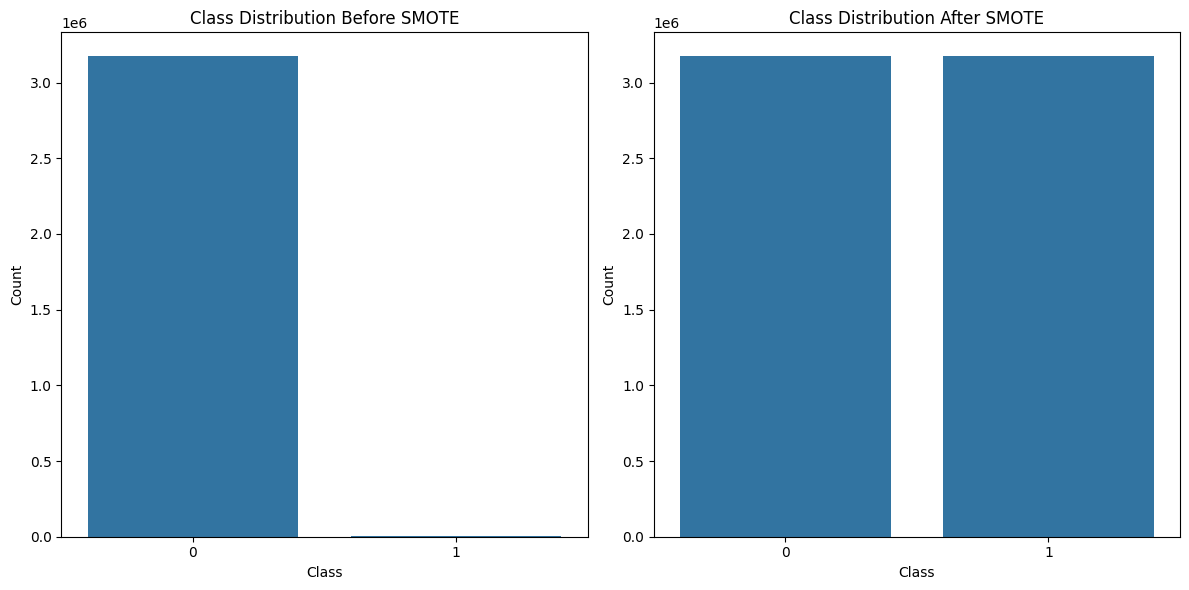

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Original class distribution:\n{pd.Series(y_train).value_counts()}")
print(f"\nResampled class distribution:\n{pd.Series(y_train_smote).value_counts()}")

# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Class distribution BEFORE SMOTE
sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Class Distribution Before SMOTE')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# Plot 2: Class distribution AFTER SMOTE
sns.countplot(x=y_train_smote, ax=ax2)
ax2.set_title('Class Distribution After SMOTE')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

# Or save it to a file
# plt.savefig('smote_comparison.png')

#  OverSampling SMOTE

In [41]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert the data into DMatrix, which is highly efficient data structure used internally by the XGBoost library.
dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
dtest = xgb.DMatrix(X_test, label=y_test)

In [45]:
dtrain.num_row(), dtrain.num_col()

(6346382, 91)

In [46]:
dtest.num_row(), dtest.num_col()

(1361470, 91)

[0]	train-logloss:0.61110	train-error:0.04910	test-logloss:0.61149	test-error:0.04118
[1]	train-logloss:0.53826	train-error:0.01806	test-logloss:0.53920	test-error:0.02821
[2]	train-logloss:0.47849	train-error:0.02093	test-logloss:0.48021	test-error:0.03931
[3]	train-logloss:0.42687	train-error:0.01804	test-logloss:0.42928	test-error:0.03352
[4]	train-logloss:0.38273	train-error:0.01872	test-logloss:0.38586	test-error:0.03501
[5]	train-logloss:0.34325	train-error:0.01589	test-logloss:0.34668	test-error:0.02975
[6]	train-logloss:0.31044	train-error:0.01503	test-logloss:0.31443	test-error:0.02843
[7]	train-logloss:0.28005	train-error:0.01427	test-logloss:0.28432	test-error:0.02715
[8]	train-logloss:0.25505	train-error:0.01367	test-logloss:0.25975	test-error:0.02596
[9]	train-logloss:0.23269	train-error:0.01313	test-logloss:0.23761	test-error:0.02502
[10]	train-logloss:0.21180	train-error:0.01243	test-logloss:0.21683	test-error:0.02369
[11]	train-logloss:0.19320	train-error:0.01143	test-l

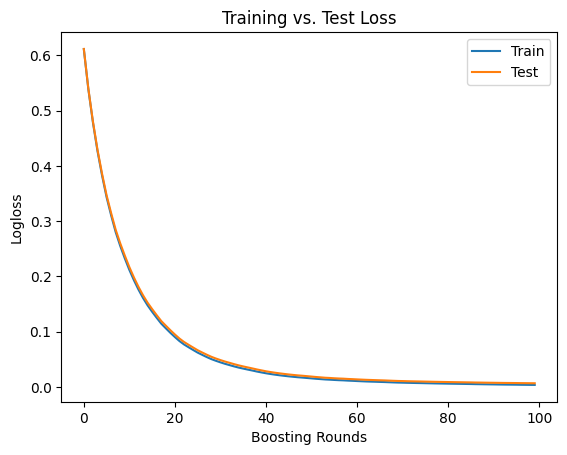

In [32]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 100
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)



# Extract the training loss from the evaluation results
train_loss = eval_results['train']['logloss']

# Extract the training *AND* test loss from the evaluation results
train_loss = eval_results['train']['logloss']
test_loss = eval_results['test']['logloss']  # <-- เพิ่มบรรทัดนี้

# Plot the training *AND* test loss curve
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')    # <-- เพิ่มบรรทัดนี้
plt.title('Training vs. Test Loss')
plt.ylabel('Logloss')
plt.xlabel('Boosting Rounds')
plt.legend()
plt.show()
plt.show()

Confusion Matrix (Counts):
 [[1359114     784]
 [   1160     412]]
TN=1359114, FP=784, FN=1160, TP=412

Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.9994    0.9993   1359898
           1     0.3445    0.2621    0.2977      1572

    accuracy                         0.9986   1361470
   macro avg     0.6718    0.6308    0.6485   1361470
weighted avg     0.9984    0.9986    0.9985   1361470



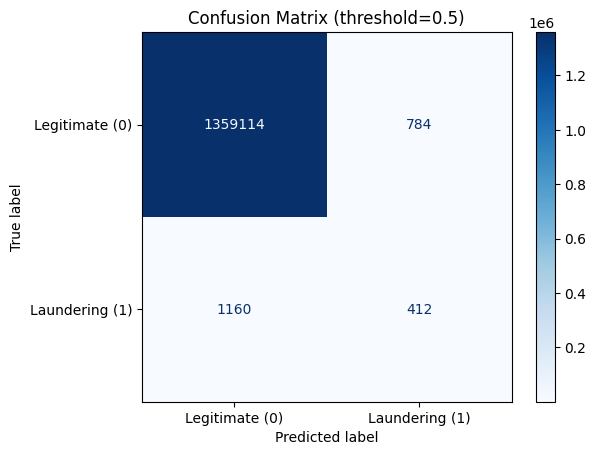

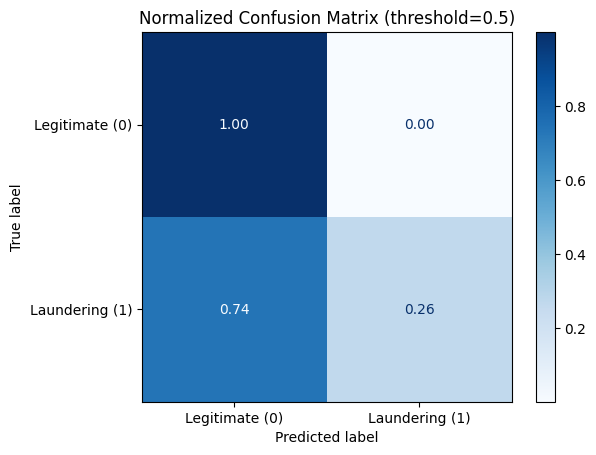

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# -----------------------------
# สร้าง prediction จากโมเดล
# -----------------------------
# Predict probability ของ class=1 (ฟอกเงิน)
y_pred_prob = bst.predict(dtest)

# กำหนด threshold (0.5 เป็นค่าเริ่มต้น)
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# -----------------------------
# สร้าง Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion Matrix (Counts):\n", cm)

# แยกค่า TN, FP, FN, TP (ช่วยเช็ค)
tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# -----------------------------
# แสดงรายงานสรุป (Precision, Recall, F1)
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# -----------------------------
# วาดกราฟ Confusion Matrix
# -----------------------------
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Legitimate (0)", "Laundering (1)"])
disp.plot(values_format='d', cmap='Blues')
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()

# วาดแบบ normalized (ดูเปอร์เซ็นต์ต่อคลาส)
cm_norm = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                                   display_labels=["Legitimate (0)", "Laundering (1)"])
disp_norm.plot(values_format=".2f", cmap="Blues")
plt.title(f"Normalized Confusion Matrix (threshold={threshold})")
plt.show()


# UnderSampling Th=best Auto June by Val

Best iteration: 520
Best threshold on VAL = 0.90 (F1_val=0.1061)

=== Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9995    0.9896    0.9945   1359917
           1     0.0601    0.5834    0.1090      1553

    accuracy                         0.9891   1361470
   macro avg     0.5298    0.7865    0.5518   1361470
weighted avg     0.9984    0.9891    0.9935   1361470

PR-AUC (test): 0.11715504271405666
Confusion matrix (test):
 [[1345755   14162]
 [    647     906]]


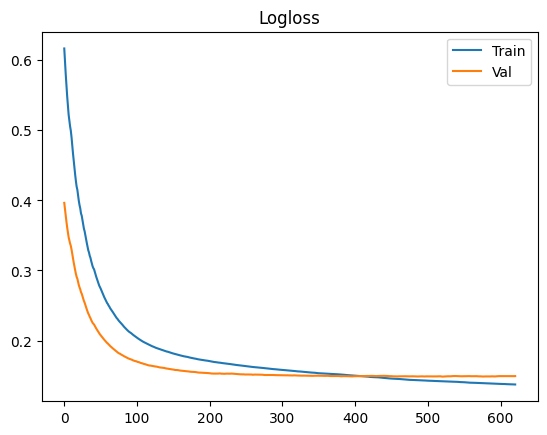

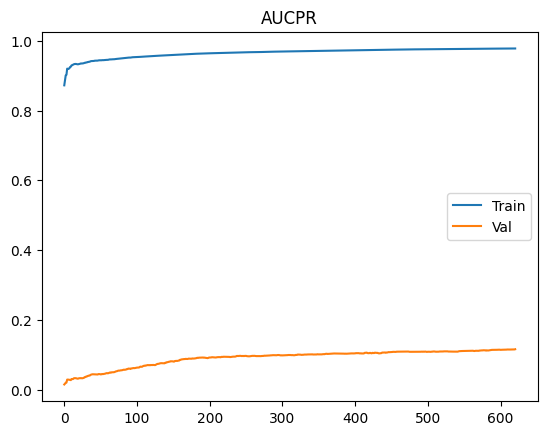

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, average_precision_score, confusion_matrix

# 1) Split (stratify สำคัญมาก)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_transformed, newdf['Is Laundering'],
    train_size=0.7, stratify=newdf['Is Laundering'], random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=42
)

# 2) RandomUnderSampler: ลด class 0 ให้เหลืออัตราส่วน 1:2 (minority:majority = 0.5)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_tr_res, y_tr_res = rus.fit_resample(X_tr, y_tr)

# 3) DMatrix
import xgboost as xgb
dtrain = xgb.DMatrix(X_tr_res, label=y_tr_res)
dval   = xgb.DMatrix(X_val,    label=y_val)
dtest  = xgb.DMatrix(X_te,     label=y_te)

# 4) Params: ใช้ aucpr + early stopping; หลัง undersample แล้วให้ scale_pos_weight=1
# --- ตั้งค่า params ให้มี AUCPR ---
# ---- Step 0: สร้าง params ก่อน ----
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['aucpr', 'logloss'],  # ใช้ metric ที่เหมาะกับ imbalance
    'eta': 0.03,            # ลด learning rate
    'max_depth': 6,         # ลดความลึกของต้นไม้
    'min_child_weight': 10, # เพิ่มเงื่อนไขการ split
    'gamma': 1.0,           # ต้องได้ gain สูงถึงจะ split
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_lambda': 2.0,      # เพิ่ม L2 regularization
    'reg_alpha': 0.3,       # เพิ่ม L1 regularization
    'scale_pos_weight': 1,  # undersample แล้วไม่ต้องถ่วงซ้ำ
    'tree_method': 'hist',
    'random_state': 42
}

# ---- Step 1: Train ----
watchlist = [(dtrain, 'train'), (dval, 'val')]
eval_results = {}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1500,
    evals=watchlist,
    evals_result=eval_results,
    early_stopping_rounds=100,
    verbose_eval=False
)

# ---- Step 2: ดึงรอบที่ดีที่สุด ----
best_iter = getattr(bst, "best_iteration", getattr(bst, "best_ntree_limit", 0))
print("Best iteration:", best_iter)

# ---- Step 3: Predict ----
def xgb_predict(bst, dmat, best_iter):
    try:
        return bst.predict(dmat, iteration_range=(0, best_iter)) if best_iter else bst.predict(dmat)
    except TypeError:
        return bst.predict(dmat, ntree_limit=best_iter) if best_iter else bst.predict(dmat)

val_prob  = xgb_predict(bst, dval,  best_iter)
test_prob = xgb_predict(bst, dtest, best_iter)

# ---- Step 4: Threshold tuning ----
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, average_precision_score

thr_grid = np.linspace(0.1, 0.9, 17)
best_thr, best_f1 = 0.5, -1
for t in thr_grid:
    f1 = f1_score(y_val, (val_prob >= t).astype(int), zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, t
print(f"Best threshold on VAL = {best_thr:.2f} (F1_val={best_f1:.4f})")

# ---- Step 5: Evaluate ----
test_pred = (test_prob >= best_thr).astype(int)
print("\n=== Test Classification Report ===")
print(classification_report(y_te, test_pred, digits=4))
print("PR-AUC (test):", average_precision_score(y_te, test_prob))
print("Confusion matrix (test):\n", confusion_matrix(y_te, test_pred))

# ---- Step 6: Learning curves ----
import matplotlib.pyplot as plt

plt.plot(eval_results['train']['logloss'], label='Train')
plt.plot(eval_results['val']['logloss'], label='Val')
plt.title('Logloss'); plt.legend(); plt.show()

if 'aucpr' in eval_results['train']:
    plt.plot(eval_results['train']['aucpr'], label='Train')
    plt.plot(eval_results['val']['aucpr'], label='Val')
    plt.title('AUCPR'); plt.legend(); plt.show()

In [72]:
from collections import Counter
print("y_tr        :", Counter(y_tr))         # train ก่อน undersample
print("y_tr_res    :", Counter(y_tr_res))     # ✅ train หลัง undersample
print("y_val       :", Counter(y_val))        # val ไม่ถูกแตะ
print("y_te        :", Counter(y_te))         # test ไม่ถูกแตะ


y_tr        : Counter({0: 2538509, 1: 2899})
y_tr_res    : Counter({0: 5798, 1: 2899})
y_val       : Counter({0: 634628, 1: 725})
y_te        : Counter({0: 1359917, 1: 1553})


Confusion Matrix (counts):
 [[1345755   14162]
 [    647     906]]
TN=1345755  FP=14162  FN=647  TP=906


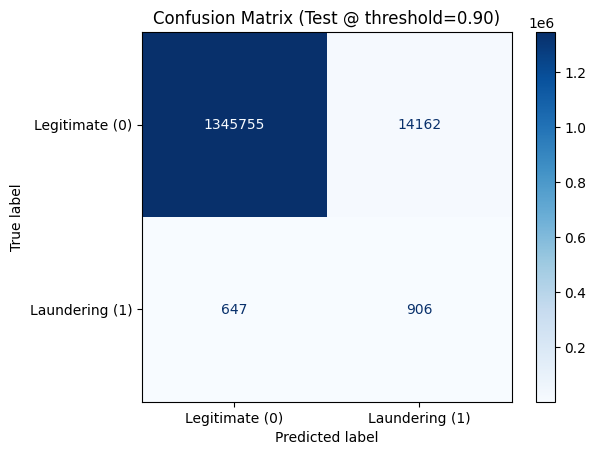

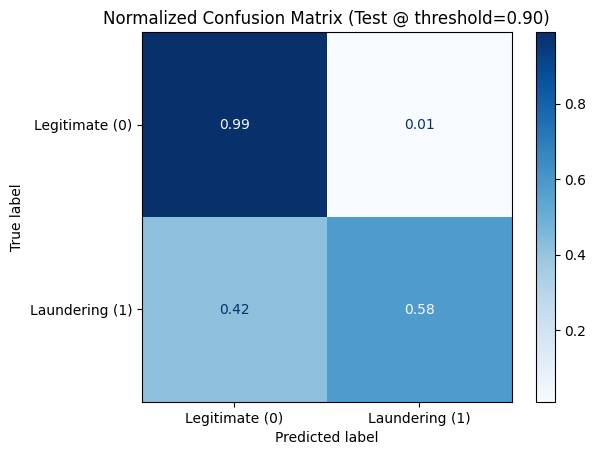

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# สร้าง Confusion Matrix (ลำดับ labels = [0, 1] = Legitimate, Laundering)
cm = confusion_matrix(y_te, test_pred, labels=[0, 1])
print("Confusion Matrix (counts):\n", cm)

# แยกค่า TN, FP, FN, TP (ช่วยเช็คค่าเฉพาะ)
tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")

# วาดกราฟแบบ counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Legitimate (0)", "Laundering (1)"])
disp.plot(values_format='d', cmap='Blues')
plt.title(f"Confusion Matrix (Test @ threshold={best_thr:.2f})")
plt.show()

# วาดกราฟแบบ normalized (ต่อแถว = recall ของแต่ละคลาส)
cm_norm = confusion_matrix(y_te, test_pred, labels=[0, 1], normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                                   display_labels=["Legitimate (0)", "Laundering (1)"])
disp_norm.plot(values_format='.2f', cmap='Blues')
plt.title(f"Normalized Confusion Matrix (Test @ threshold={best_thr:.2f})")
plt.show()


# UnderSampling Th=0.7

Best iteration: 520

=== Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9998    0.9676    0.9834   1359917
           1     0.0271    0.7882    0.0523      1553

    accuracy                         0.9674   1361470
   macro avg     0.5134    0.8779    0.5179   1361470
weighted avg     0.9986    0.9674    0.9824   1361470

PR-AUC (test): 0.11715504271405666
Confusion matrix (test):
 [[1315919   43998]
 [    329    1224]]


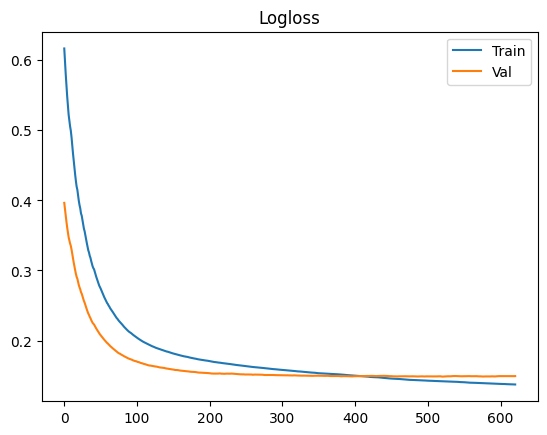

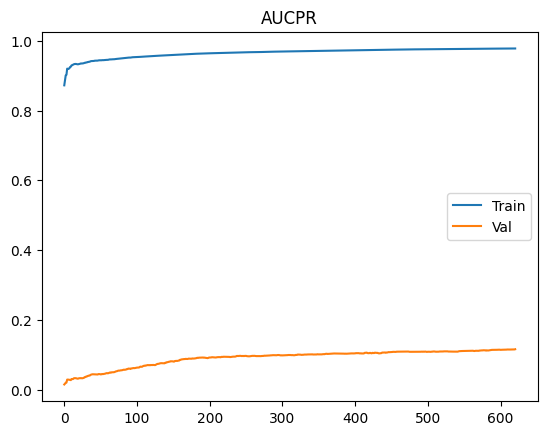

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, average_precision_score, confusion_matrix

# 1) Split (stratify สำคัญมาก)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_transformed, newdf['Is Laundering'],
    train_size=0.7, stratify=newdf['Is Laundering'], random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=42
)

# 2) RandomUnderSampler: ลด class 0 ให้เหลืออัตราส่วน 1:2 (minority:majority = 0.5)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_tr_res, y_tr_res = rus.fit_resample(X_tr, y_tr)

# 3) DMatrix
import xgboost as xgb
dtrain = xgb.DMatrix(X_tr_res, label=y_tr_res)
dval   = xgb.DMatrix(X_val,    label=y_val)
dtest  = xgb.DMatrix(X_te,     label=y_te)

# 4) Params: ใช้ aucpr + early stopping; หลัง undersample แล้วให้ scale_pos_weight=1
# --- ตั้งค่า params ให้มี AUCPR ---
# ---- Step 0: สร้าง params ก่อน ----
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['aucpr', 'logloss'],  # ใช้ metric ที่เหมาะกับ imbalance
    'eta': 0.03,            # ลด learning rate
    'max_depth': 6,         # ลดความลึกของต้นไม้
    'min_child_weight': 10, # เพิ่มเงื่อนไขการ split
    'gamma': 1.0,           # ต้องได้ gain สูงถึงจะ split
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_lambda': 2.0,      # เพิ่ม L2 regularization
    'reg_alpha': 0.3,       # เพิ่ม L1 regularization
    'scale_pos_weight': 1,  # undersample แล้วไม่ต้องถ่วงซ้ำ
    'tree_method': 'hist',
    'random_state': 42
}

# ---- Step 1: Train ----
watchlist = [(dtrain, 'train'), (dval, 'val')]
eval_results = {}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1500,
    evals=watchlist,
    evals_result=eval_results,
    early_stopping_rounds=100,
    verbose_eval=False
)

# ---- Step 2: ดึงรอบที่ดีที่สุด ----
best_iter = getattr(bst, "best_iteration", getattr(bst, "best_ntree_limit", 0))
print("Best iteration:", best_iter)

# ---- Step 3: Predict ----
def xgb_predict(bst, dmat, best_iter):
    try:
        return bst.predict(dmat, iteration_range=(0, best_iter)) if best_iter else bst.predict(dmat)
    except TypeError:
        return bst.predict(dmat, ntree_limit=best_iter) if best_iter else bst.predict(dmat)

val_prob  = xgb_predict(bst, dval,  best_iter)
test_prob = xgb_predict(bst, dtest, best_iter)

# ---- Step 4: Threshold tuning ----
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, average_precision_score

thr_grid = np.linspace(0.1, 0.9, 17)
best_thr = 0.7

# ---- Step 5: Evaluate ----
test_pred = (test_prob >= best_thr).astype(int)
print("\n=== Test Classification Report ===")
print(classification_report(y_te, test_pred, digits=4))
print("PR-AUC (test):", average_precision_score(y_te, test_prob))
print("Confusion matrix (test):\n", confusion_matrix(y_te, test_pred))

# ---- Step 6: Learning curves ----
import matplotlib.pyplot as plt

plt.plot(eval_results['train']['logloss'], label='Train')
plt.plot(eval_results['val']['logloss'], label='Val')
plt.title('Logloss'); plt.legend(); plt.show()

if 'aucpr' in eval_results['train']:
    plt.plot(eval_results['train']['aucpr'], label='Train')
    plt.plot(eval_results['val']['aucpr'], label='Val')
    plt.title('AUCPR'); plt.legend(); plt.show()

In [81]:
from collections import Counter
print("y_tr        :", Counter(y_tr))         # train ก่อน undersample
print("y_tr_res    :", Counter(y_tr_res))     # ✅ train หลัง undersample
print("y_val       :", Counter(y_val))        # val ไม่ถูกแตะ
print("y_te        :", Counter(y_te))         # test ไม่ถูกแตะ


y_tr        : Counter({0: 2538509, 1: 2899})
y_tr_res    : Counter({0: 5798, 1: 2899})
y_val       : Counter({0: 634628, 1: 725})
y_te        : Counter({0: 1359917, 1: 1553})


In [82]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_te, test_pred, digits=4))
print(confusion_matrix(y_te, test_pred))


              precision    recall  f1-score   support

           0     0.9998    0.9676    0.9834   1359917
           1     0.0271    0.7882    0.0523      1553

    accuracy                         0.9674   1361470
   macro avg     0.5134    0.8779    0.5179   1361470
weighted avg     0.9986    0.9674    0.9824   1361470

[[1315919   43998]
 [    329    1224]]


Confusion Matrix (counts):
 [[1315919   43998]
 [    329    1224]]
TN=1315919  FP=43998  FN=329  TP=1224


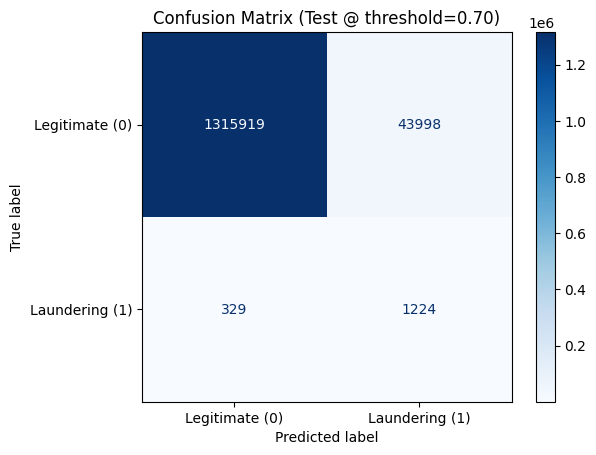

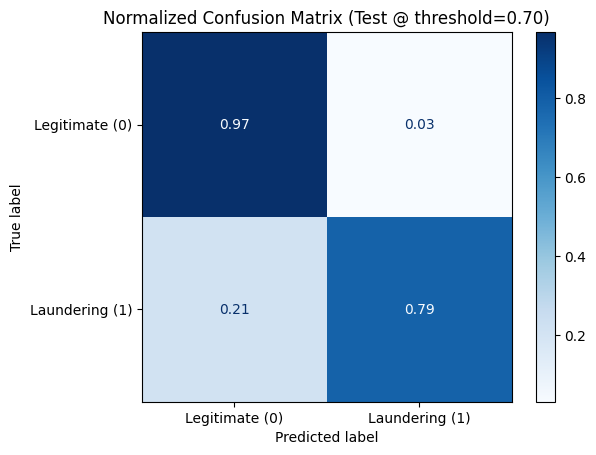

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# สร้าง Confusion Matrix (ลำดับ labels = [0, 1] = Legitimate, Laundering)
cm = confusion_matrix(y_te, test_pred, labels=[0, 1])
print("Confusion Matrix (counts):\n", cm)

# แยกค่า TN, FP, FN, TP (ช่วยเช็คค่าเฉพาะ)
tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")

# วาดกราฟแบบ counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Legitimate (0)", "Laundering (1)"])
disp.plot(values_format='d', cmap='Blues')
plt.title(f"Confusion Matrix (Test @ threshold={best_thr:.2f})")
plt.show()

# วาดกราฟแบบ normalized (ต่อแถว = recall ของแต่ละคลาส)
cm_norm = confusion_matrix(y_te, test_pred, labels=[0, 1], normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                                   display_labels=["Legitimate (0)", "Laundering (1)"])
disp_norm.plot(values_format='.2f', cmap='Blues')
plt.title(f"Normalized Confusion Matrix (Test @ threshold={best_thr:.2f})")
plt.show()


# UnderSampling Th=0.5

Best iteration: 520

=== Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9998    0.9344    0.9660   1359917
           1     0.0147    0.8583    0.0289      1553

    accuracy                         0.9343   1361470
   macro avg     0.5073    0.8964    0.4975   1361470
weighted avg     0.9987    0.9343    0.9649   1361470

PR-AUC (test): 0.11715504271405666
Confusion matrix (test):
 [[1270655   89262]
 [    220    1333]]


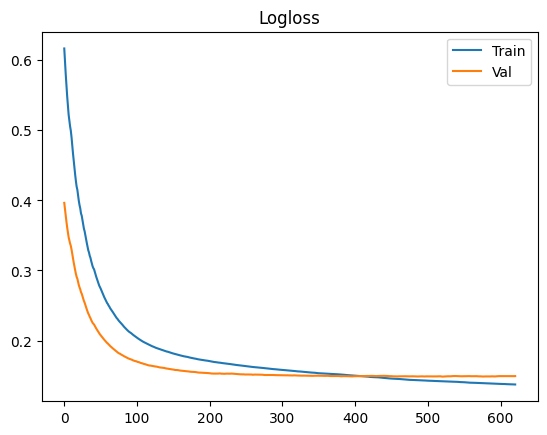

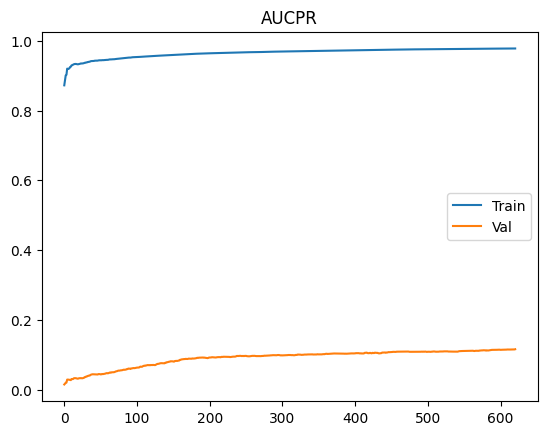

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, average_precision_score, confusion_matrix

# 1) Split (stratify สำคัญมาก)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_transformed, newdf['Is Laundering'],
    train_size=0.7, stratify=newdf['Is Laundering'], random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=42
)

# 2) RandomUnderSampler: ลด class 0 ให้เหลืออัตราส่วน 1:2 (minority:majority = 0.5)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_tr_res, y_tr_res = rus.fit_resample(X_tr, y_tr)

# 3) DMatrix
import xgboost as xgb
dtrain = xgb.DMatrix(X_tr_res, label=y_tr_res)
dval   = xgb.DMatrix(X_val,    label=y_val)
dtest  = xgb.DMatrix(X_te,     label=y_te)

# 4) Params: ใช้ aucpr + early stopping; หลัง undersample แล้วให้ scale_pos_weight=1
# --- ตั้งค่า params ให้มี AUCPR ---
# ---- Step 0: สร้าง params ก่อน ----
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['aucpr', 'logloss'],  # ใช้ metric ที่เหมาะกับ imbalance
    'eta': 0.03,            # ลด learning rate
    'max_depth': 6,         # ลดความลึกของต้นไม้
    'min_child_weight': 10, # เพิ่มเงื่อนไขการ split
    'gamma': 1.0,           # ต้องได้ gain สูงถึงจะ split
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_lambda': 2.0,      # เพิ่ม L2 regularization
    'reg_alpha': 0.3,       # เพิ่ม L1 regularization
    'scale_pos_weight': 1,  # undersample แล้วไม่ต้องถ่วงซ้ำ
    'tree_method': 'hist',
    'random_state': 42
}

# ---- Step 1: Train ----
watchlist = [(dtrain, 'train'), (dval, 'val')]
eval_results = {}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1500,
    evals=watchlist,
    evals_result=eval_results,
    early_stopping_rounds=100,
    verbose_eval=False
)

# ---- Step 2: ดึงรอบที่ดีที่สุด ----
best_iter = getattr(bst, "best_iteration", getattr(bst, "best_ntree_limit", 0))
print("Best iteration:", best_iter)

# ---- Step 3: Predict ----
def xgb_predict(bst, dmat, best_iter):
    try:
        return bst.predict(dmat, iteration_range=(0, best_iter)) if best_iter else bst.predict(dmat)
    except TypeError:
        return bst.predict(dmat, ntree_limit=best_iter) if best_iter else bst.predict(dmat)

val_prob  = xgb_predict(bst, dval,  best_iter)
test_prob = xgb_predict(bst, dtest, best_iter)

# ---- Step 4: Threshold tuning ----
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, average_precision_score

thr_grid = np.linspace(0.1, 0.9, 17)
best_thr = 0.5

# ---- Step 5: Evaluate ----
test_pred = (test_prob >= best_thr).astype(int)
print("\n=== Test Classification Report ===")
print(classification_report(y_te, test_pred, digits=4))
print("PR-AUC (test):", average_precision_score(y_te, test_prob))
print("Confusion matrix (test):\n", confusion_matrix(y_te, test_pred))

# ---- Step 6: Learning curves ----
import matplotlib.pyplot as plt

plt.plot(eval_results['train']['logloss'], label='Train')
plt.plot(eval_results['val']['logloss'], label='Val')
plt.title('Logloss'); plt.legend(); plt.show()

if 'aucpr' in eval_results['train']:
    plt.plot(eval_results['train']['aucpr'], label='Train')
    plt.plot(eval_results['val']['aucpr'], label='Val')
    plt.title('AUCPR'); plt.legend(); plt.show()

In [85]:
from collections import Counter
print("y_tr        :", Counter(y_tr))         # train ก่อน undersample
print("y_tr_res    :", Counter(y_tr_res))     # ✅ train หลัง undersample
print("y_val       :", Counter(y_val))        # val ไม่ถูกแตะ
print("y_te        :", Counter(y_te))         # test ไม่ถูกแตะ


y_tr        : Counter({0: 2538509, 1: 2899})
y_tr_res    : Counter({0: 5798, 1: 2899})
y_val       : Counter({0: 634628, 1: 725})
y_te        : Counter({0: 1359917, 1: 1553})


In [86]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_te, test_pred, digits=4))
print(confusion_matrix(y_te, test_pred))


              precision    recall  f1-score   support

           0     0.9998    0.9344    0.9660   1359917
           1     0.0147    0.8583    0.0289      1553

    accuracy                         0.9343   1361470
   macro avg     0.5073    0.8964    0.4975   1361470
weighted avg     0.9987    0.9343    0.9649   1361470

[[1270655   89262]
 [    220    1333]]


Confusion Matrix (counts):
 [[1270655   89262]
 [    220    1333]]
TN=1270655  FP=89262  FN=220  TP=1333


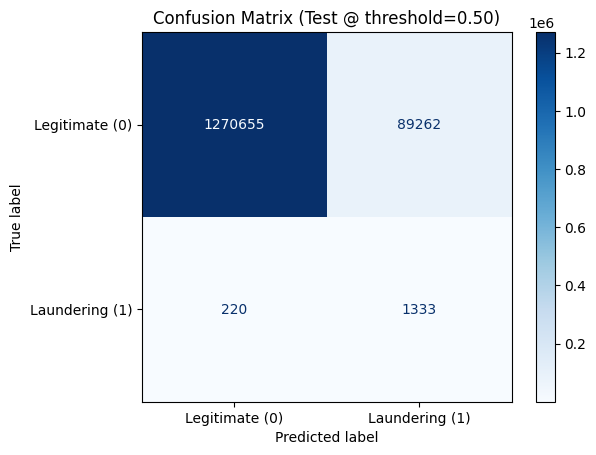

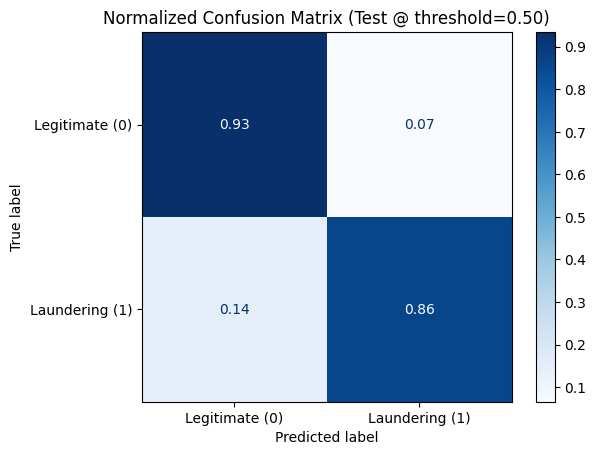

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# สร้าง Confusion Matrix (ลำดับ labels = [0, 1] = Legitimate, Laundering)
cm = confusion_matrix(y_te, test_pred, labels=[0, 1])
print("Confusion Matrix (counts):\n", cm)

# แยกค่า TN, FP, FN, TP (ช่วยเช็คค่าเฉพาะ)
tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")

# วาดกราฟแบบ counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Legitimate (0)", "Laundering (1)"])
disp.plot(values_format='d', cmap='Blues')
plt.title(f"Confusion Matrix (Test @ threshold={best_thr:.2f})")
plt.show()

# วาดกราฟแบบ normalized (ต่อแถว = recall ของแต่ละคลาส)
cm_norm = confusion_matrix(y_te, test_pred, labels=[0, 1], normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                                   display_labels=["Legitimate (0)", "Laundering (1)"])
disp_norm.plot(values_format='.2f', cmap='Blues')
plt.title(f"Normalized Confusion Matrix (Test @ threshold={best_thr:.2f})")
plt.show()
